In [4]:
import zipfile
import os

dataset_zip = "/content/cicids2017-cleaned-and-preprocessed.zip"
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import load_model
from tqdm import tqdm

In [7]:
from tensorflow.keras.models import load_model

autoencoder = load_model("/content/drive/MyDrive/Model Weights/autoencoder_model_RMS_LR.h5", compile=False)
rnn_model = load_model("/content/drive/MyDrive/Model Weights/rnn1_model.h5", compile=False)


In [52]:
# === Load data ===
df = pd.read_csv('/content/dataset/cicids2017_cleaned.csv')
label_map = {'Bots': 0, 'Brute Force': 1, 'DDoS': 2, 'DoS': 3, 'Normal Traffic': 4, 'Port Scanning': 5, 'Web Attacks': 6}
inv_label_map = {v: k for k, v in label_map.items()}

true_labels = df['Attack Type'].map(label_map).values
features = df.drop(columns=['Attack Type']).values

In [53]:
# === Scaling ===
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

In [54]:
# === Settings ===
batch_size = 2000000
threshold = 0.000026

In [55]:
# === Storage ===
predictions = []
true_labels_adjusted = []

In [56]:
# === Batch processing ===
for i in tqdm(range(0, len(features_scaled), batch_size)):
    end = min(i + batch_size, len(features_scaled))
    batch_x = features_scaled[i:end]
    batch_labels = true_labels[i:end]

    # Step 1: Autoencoder
    reconstructions = autoencoder.predict(batch_x)
    batch_mse = np.mean(np.power(batch_x - reconstructions, 2), axis=1)

    # Step 2: Filter & prepare for RNN
    ae_flags = batch_mse >= threshold
    rnn_input = batch_x[ae_flags]

    # Step 3: RNN only for flagged anomalies
    if len(rnn_input) > 0:
        rnn_preds = rnn_model.predict(rnn_input)
        rnn_classes = np.argmax(rnn_preds, axis=1)
        rnn_confidences = np.max(rnn_preds, axis=1)

    else:
        rnn_classes = []

    # Step 4: Compose predictions
    rnn_idx = 0
    for j in range(len(batch_x)):
        true_label = batch_labels[j]

        if not ae_flags[j]:
            pred = 4  # Autoencoder says normal → predict normal
        else:
            rnn_class = rnn_classes[rnn_idx]
            rnn_confidence = rnn_confidences[rnn_idx]
            rnn_idx += 1

            if rnn_class != 4:
                pred = rnn_class
            else:
                if batch_mse[j] > 0.1:
                    pred = 7  # Other
                elif rnn_confidence < 0.6 and batch_mse[j] >= 0.000026:
                    pred = 7  # Other
                else:
                    pred = 4  # Normal

        predictions.append(pred)

        # Adjust true labels for "Other" class
        if pred == 7:
            if true_label != 4:
                true_labels_adjusted.append(7)  # Intrusion labeled as Other → OK
            else:
                true_labels_adjusted.append(4)  # Normal wrongly labeled as Other
        else:
            true_labels_adjusted.append(true_label)

  0%|          | 0/2 [00:00<?, ?it/s]

62500/62500 ━━━━━━━━━━━━━━━━━━━━ 84s 1ms/step
35973/35973 ━━━━━━━━━━━━━━━━━━━━ 174s 5ms/step


 50%|█████     | 1/2 [05:22<05:22, 322.02s/it]

16274/16274 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step
10691/10691 ━━━━━━━━━━━━━━━━━━━━ 51s 5ms/step


100%|██████████| 2/2 [07:18<00:00, 219.02s/it]


In [57]:
# === Final Evaluation ===
target_names = [inv_label_map[i] for i in range(7)] + ['Other']
print("\nClassification Report:")
print(classification_report(true_labels_adjusted, predictions, target_names=target_names))

overall_acc = accuracy_score(true_labels_adjusted, predictions)
print(f"\nOverall Accuracy: {overall_acc:.4f}")



Classification Report:
                precision    recall  f1-score   support

          Bots       0.57      0.73      0.64      1838
   Brute Force       1.00      0.97      0.99      9150
          DDoS       1.00      1.00      1.00    128014
           DoS       0.99      0.99      0.99    193623
Normal Traffic       1.00      1.00      1.00   2095057
 Port Scanning       0.99      1.00      0.99     90693
   Web Attacks       0.89      0.99      0.94      2120
         Other       0.26      1.00      0.41       256

      accuracy                           1.00   2520751
     macro avg       0.84      0.96      0.87   2520751
  weighted avg       1.00      1.00      1.00   2520751


Overall Accuracy: 0.9968


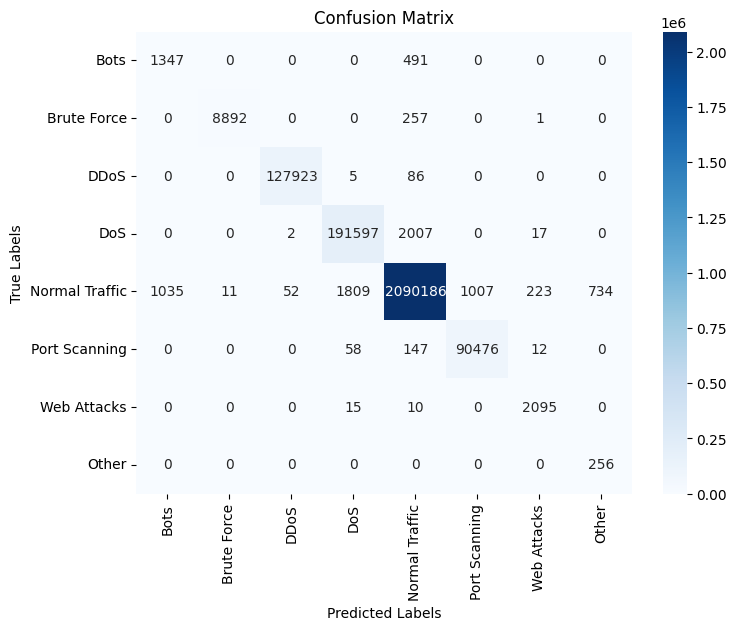

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(true_labels_adjusted, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [15]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/IDS_Dataset.csv")

In [16]:
df.columns = df.columns.str.strip()
df.rename(columns={'Label': 'Attack Type'}, inplace=True)

In [17]:
columns_to_keep = [
    'Destination Port', 'Flow Duration', 'Total Fwd Packets',
    'Total Length of Fwd Packets', 'Fwd Packet Length Max',
    'Fwd Packet Length Min', 'Fwd Packet Length Mean',
    'Fwd Packet Length Std', 'Bwd Packet Length Max',
    'Bwd Packet Length Min', 'Bwd Packet Length Mean',
    'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
    'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
    'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
    'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
    'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Length', 'Bwd Header Length',
    'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length',
    'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
    'Packet Length Variance', 'FIN Flag Count', 'PSH Flag Count',
    'ACK Flag Count', 'Average Packet Size', 'Subflow Fwd Bytes',
    'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'act_data_pkt_fwd',
    'min_seg_size_forward', 'Active Mean', 'Active Max', 'Active Min',
    'Idle Mean', 'Idle Max', 'Idle Min', 'Attack Type'
]

df = df[columns_to_keep]


In [18]:
infiltration_df = df[df['Attack Type'] == 'Infiltration']
heartbleed_df = df[df['Attack Type'] == 'Heartbleed']

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from tensorflow.keras.models import load_model

In [20]:
# Prepare features and labels
X_infil = infiltration_df.drop('Attack Type', axis=1).values
y_infil = np.ones(len(infiltration_df))  # All are attacks

In [21]:
# Normalize using MinMaxScaler (same as used during training)
scaler = MinMaxScaler()
X_infil_scaled = scaler.fit_transform(X_infil)

In [22]:
# === Batch processing ===
for i in tqdm(range(0, len(X_infil_scaled), batch_size)):
    end = min(i + batch_size, len(X_infil_scaled))
    batch_x = X_infil_scaled[i:end]
    batch_labels = true_labels[i:end]

    # Step 1: Autoencoder
    reconstructions = autoencoder.predict(batch_x)
    batch_mse = np.mean(np.power(batch_x - reconstructions, 2), axis=1)

    # Step 2: Filter & prepare for RNN
    ae_flags = batch_mse >= threshold
    rnn_input = batch_x[ae_flags]

    # Step 3: RNN only for flagged anomalies
    if len(rnn_input) > 0:
        rnn_preds = rnn_model.predict(rnn_input)
        rnn_classes = np.argmax(rnn_preds, axis=1)
        rnn_confidences = np.max(rnn_preds, axis=1)

    else:
        rnn_classes = []

    # Step 4: Compose predictions
    rnn_idx = 0
    for j in range(len(batch_x)):
        true_label = batch_labels[j]

        if not ae_flags[j]:
            pred = 4  # Autoencoder says normal → predict normal
        else:
            rnn_class = rnn_classes[rnn_idx]
            rnn_confidence = rnn_confidences[rnn_idx]
            rnn_idx += 1

            if rnn_class != 4:
                pred = rnn_class
            else:
                if batch_mse[j] > 0.1:
                    pred = 7  # Other
                elif rnn_confidence < 0.6 and batch_mse[j] >= 0.000026:
                    pred = 7  # Other
                else:
                    pred = 4  # Normal

        predictions.append(pred)

        # Adjust true labels for "Other" class
        if pred == 7:
            if true_label != 4:
                true_labels_adjusted.append(7)  # Intrusion labeled as Other → OK
            else:
                true_labels_adjusted.append(4)  # Normal wrongly labeled as Other
        else:
            true_labels_adjusted.append(true_label)

  0%|          | 0/1 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from tensorflow.keras.models import load_model
from tqdm import tqdm

# Prepare features and labels for 'Infiltration' attacks
infiltration_df = df[df['Attack Type'] == 'Infiltration']

X_infil = infiltration_df.drop('Attack Type', axis=1).values
y_infil = np.ones(len(infiltration_df))  # All are attacks

# Normalize using MinMaxScaler (same as used during training)
scaler = MinMaxScaler()
X_infil_scaled = scaler.fit_transform(X_infil)

# Initialize variables to collect predictions and true labels
predictions = []
true_labels_adjusted = []

# === Batch processing ===
batch_size = 32
threshold = 0.000026

true_labels = y_infil

for i in tqdm(range(0, len(X_infil_scaled), batch_size)):
    end = min(i + batch_size, len(X_infil_scaled))
    batch_x = X_infil_scaled[i:end]
    batch_labels = true_labels[i:end]

    # Step 1: Autoencoder
    reconstructions = autoencoder.predict(batch_x)
    batch_mse = np.mean(np.power(batch_x - reconstructions, 2), axis=1)

    # Step 2: Filter & prepare for RNN
    ae_flags = batch_mse >= threshold
    rnn_input = batch_x[ae_flags]

    # Step 3: RNN only for flagged anomalies
    if len(rnn_input) > 0:
        rnn_preds = rnn_model.predict(rnn_input)
        rnn_classes = np.argmax(rnn_preds, axis=1)
        rnn_confidences = np.max(rnn_preds, axis=1)
    else:
        rnn_classes = []

    # Step 4: Compose predictions
    rnn_idx = 0
    for j in range(len(batch_x)):
        true_label = batch_labels[j]

        if not ae_flags[j]:
            pred = 4  # Autoencoder says normal → predict normal
        else:
            rnn_class = rnn_classes[rnn_idx] if len(rnn_classes) > rnn_idx else 4
            rnn_confidence = rnn_confidences[rnn_idx] if len(rnn_confidences) > rnn_idx else 1.0
            rnn_idx += 1

            if rnn_class != 4:
                pred = rnn_class
            else:
                if batch_mse[j] > 0.1:
                    pred = 7  # Other
                elif rnn_confidence < 0.6 and batch_mse[j] >= 0.000026:
                    pred = 7  # Other
                else:
                    pred = 4  # Normal

        predictions.append(pred)

        # Adjust true labels for "Other" class
        if pred == 7:
            if true_label != 4:
                true_labels_adjusted.append(7)  # Intrusion labeled as Other → OK
            else:
                true_labels_adjusted.append(4)  # Normal wrongly labeled as Other
        else:
            true_labels_adjusted.append(true_label)

# Generate classification report
print(classification_report(true_labels_adjusted, predictions, zero_division=0))



  0%|          | 0/2 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|█████     | 1/2 [00:00<00:00,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


100%|██████████| 2/2 [00:00<00:00,  4.50it/s]

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         5
         4.0       0.00      0.00      0.00         0
         7.0       1.00      1.00      1.00        31

    accuracy                           0.86        36
   macro avg       0.33      0.33      0.33        36
weighted avg       0.86      0.86      0.86        36



In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from tensorflow.keras.models import load_model
from tqdm import tqdm

heartbleed_df = df[df['Attack Type'] == 'Heartbleed']

X_heart = heartbleed_df.drop('Attack Type', axis=1).values
y_heart = np.ones(len(heartbleed_df))  # All are attacks

# Normalize using MinMaxScaler (same as used during training)
scaler = MinMaxScaler()
X_infil_scaled = scaler.fit_transform(X_heart)

# Initialize variables to collect predictions and true labels
predictions = []
true_labels_adjusted = []

# === Batch processing ===
batch_size = 32
threshold = 0.000026

true_labels = y_heart

for i in tqdm(range(0, len(X_infil_scaled), batch_size)):
    end = min(i + batch_size, len(X_infil_scaled))
    batch_x = X_infil_scaled[i:end]
    batch_labels = true_labels[i:end]

    # Step 1: Autoencoder
    reconstructions = autoencoder.predict(batch_x)
    batch_mse = np.mean(np.power(batch_x - reconstructions, 2), axis=1)

    # Step 2: Filter & prepare for RNN
    ae_flags = batch_mse >= threshold
    rnn_input = batch_x[ae_flags]

    # Step 3: RNN only for flagged anomalies
    if len(rnn_input) > 0:
        rnn_preds = rnn_model.predict(rnn_input)
        rnn_classes = np.argmax(rnn_preds, axis=1)
        rnn_confidences = np.max(rnn_preds, axis=1)
    else:
        rnn_classes = []

    # Step 4: Compose predictions
    rnn_idx = 0
    for j in range(len(batch_x)):
        true_label = batch_labels[j]

        if not ae_flags[j]:
            pred = 4  # Autoencoder says normal → predict normal
        else:
            rnn_class = rnn_classes[rnn_idx] if len(rnn_classes) > rnn_idx else 4
            rnn_confidence = rnn_confidences[rnn_idx] if len(rnn_confidences) > rnn_idx else 1.0
            rnn_idx += 1

            if rnn_class != 4:
                pred = rnn_class
            else:
                if batch_mse[j] > 0.1:
                    pred = 7  # Other
                elif rnn_confidence < 0.6 and batch_mse[j] >= 0.000026:
                    pred = 7  # Other
                else:
                    pred = 4  # Normal

        predictions.append(pred)

        # Adjust true labels for "Other" class
        if pred == 7:
            if true_label != 4:
                true_labels_adjusted.append(7)  # Intrusion labeled as Other → OK
            else:
                true_labels_adjusted.append(4)  # Normal wrongly labeled as Other
        else:
            true_labels_adjusted.append(true_label)

# Generate classification report
print(classification_report(true_labels_adjusted, predictions, zero_division=0))



  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]

              precision    recall  f1-score   support

           7       1.00      1.00      1.00        11

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

